In [ ]:
pip install pgmpy

## Ejemplo 1: Markov Models

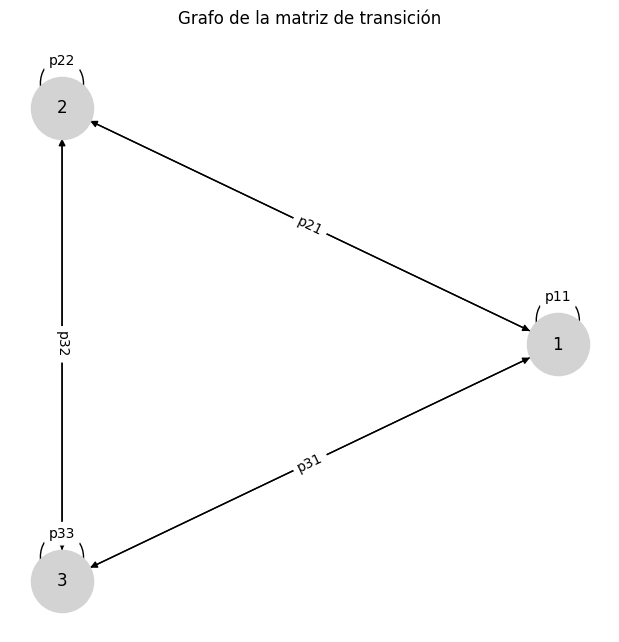

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear grafo dirigido
G = nx.DiGraph()

# Nodos (estados)
states = [1, 2, 3]
G.add_nodes_from(states)

# Aristas con etiquetas p_ij
edge_labels = {}
for i in states:
    for j in states:
        G.add_edge(i, j)
        edge_labels[(i, j)] = f"p{i}{j}"

# Posiciones para visualización
pos = nx.circular_layout(G)

# Dibujar grafo
plt.figure(figsize=(6, 6))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,
    node_color="lightgray",
    arrows=True
)

# Dibujar etiquetas de aristas
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=10
)

plt.title("Grafo de la matriz de transición")
plt.show()


$$ P_{transition} =
\begin{pmatrix}
    p_{11} & p_{12} & p_{13}\\
    p_{21} & p_{22} & p_{23}\\
    p_{31} & p_{32} & p_{33}\\
\end{pmatrix}$$

$$p_{init} =
\begin{pmatrix} 0.1 & 0.8 & 0.1
\end{pmatrix}
$$

In [ ]:
import numpy as np
p_init = np.array([0.1, 0.8, 0.1])


In [ ]:
p_transition = np.array(
    [[0.90, 0.05, 0.05],
     [0.01, 0.90, 0.09],
     [0.07, 0.03, 0.9]]
)
p_transition

array([[0.9 , 0.05, 0.05],
       [0.01, 0.9 , 0.09],
       [0.07, 0.03, 0.9 ]])

In [ ]:
p_transition[0, :].sum()

np.float64(1.0)

In [ ]:
p_transition[1, :].sum()

np.float64(1.0)

In [ ]:
p_transition[1, :].sum()

np.float64(1.0)

In [ ]:
p_next = p_init @ p_transition
p_next

array([0.105, 0.728, 0.167])

In [ ]:
p_next = p_next @ p_transition
p_next

array([0.11347, 0.66546, 0.22107])

In [ ]:
p_state_t = [p_init]

for i in range(200):  # 200 time steps sorta, kinda, approximates infinite time :)
    p_state_t.append(p_state_t[-1] @ p_transition)


In [ ]:
import pandas as pd

state_distributions = pd.DataFrame(p_state_t)
state_distributions

,0,1,2
0,0.100000,0.800000,0.100000
1,0.105000,0.728000,0.167000
2,0.113470,0.665460,0.221070
3,0.124253,0.611220,0.264528
4,0.136456,0.564246,0.299297
...,...,...,...
196,0.313305,0.278970,0.407725
197,0.313305,0.278970,0.407725
198,0.313305,0.278970,0.407725
199,0.313305,0.278970,0.407725


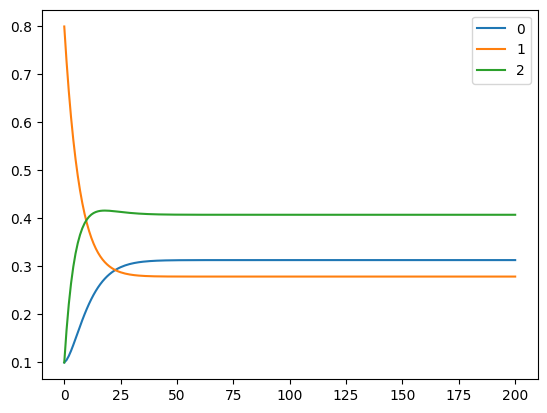

In [ ]:
import matplotlib.pyplot as plt
state_distributions.plot();

## Ejemplo 2: Bayesian Networks

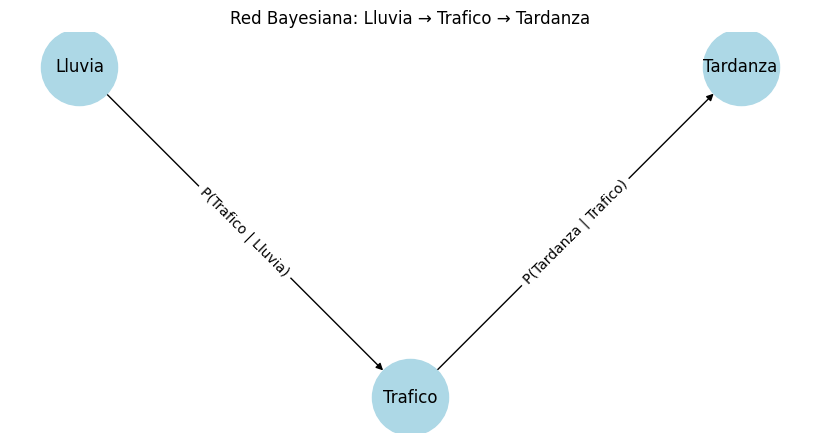

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear grafo dirigido
G = nx.DiGraph()

# Agregar nodos
G.add_nodes_from(['Lluvia', 'Trafico', 'Tardanza'])

# Agregar aristas
G.add_edge('Lluvia', 'Trafico')
G.add_edge('Trafico', 'Tardanza')

# Etiquetas de aristas (CPDs)
edge_labels = {
    ('Lluvia', 'Trafico'): 'P(Trafico | Lluvia)',
    ('Trafico', 'Tardanza'): 'P(Tardanza | Trafico)'
}

# Posiciones manuales para mejor lectura
pos = {
    'Lluvia': (0, 1),
    'Trafico': (1, 0),
    'Tardanza': (2, 1)
}

# Dibujar grafo
plt.figure(figsize=(8, 4))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=3000,
    node_color='lightblue',
    arrows=True
)

# Dibujar etiquetas de aristas
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=10
)

plt.title("Red Bayesiana: Lluvia → Trafico → Tardanza")
plt.axis('off')
plt.show()


In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

#
model = DiscreteBayesianNetwork(
    [('Lluvia', 'Trafico'),
     ('Trafico', 'Tardanza')]
    )

# Definir las Tablas de Probabilidad Condicional (CPD)
# CPD Lluvia: P(Lluvia)
cpd_lluvia = TabularCPD(variable='Lluvia', variable_card=2, values=[[0.8], [0.2]]) # [No, Si]

# CPD Trafico: P(Trafico | Lluvia)
# Si no llueve (0), hay tráfico (1) con prob 0.1. Si llueve (1), hay tráfico (1) con prob 0.6.
cpd_trafico = TabularCPD(variable='Trafico', variable_card=2,
                         values=[[0.9, 0.4],  # No hay tráfico
                                 [0.1, 0.6]], # Sí hay tráfico
                         evidence=['Lluvia'], evidence_card=[2])

# CPD Tardanza: P(Tardanza | Trafico)
cpd_tardanza = TabularCPD(variable='Tardanza', variable_card=2,
                          values=[[0.9, 0.2],  # No llega tarde
                                  [0.1, 0.8]], # Sí llega tarde
                          evidence=['Trafico'], evidence_card=[2])

# Asociar las tablas al modelo
model.add_cpds(cpd_lluvia, cpd_trafico, cpd_tardanza)


In [ ]:
# Validar si el modelo es consistente (suma de probabilidades = 1)
print(f"¿Modelo válido?: {model.check_model()}")

¿Modelo válido?: True


In [ ]:
# ¿Cuál es la probabilidad de llegar tarde si sabemos que ESTÁ LLOVIENDO?
infer = VariableElimination(model)
query = infer.query(variables=['Tardanza'], evidence={'Lluvia': 1})
print("\nProbabilidad de Tardanza dado que Llueve:")
print(query)


Probabilidad de Tardanza dado que Llueve:
+-------------+-----------------+
| Tardanza    |   phi(Tardanza) |
+=============+=================+
| Tardanza(0) |          0.4800 |
+-------------+-----------------+
| Tardanza(1) |          0.5200 |
+-------------+-----------------+
